# 課題4
* あなたなら、どのように事前分布を決める？
* その決め方にしたがって分析をおこない、$p(\mu_s > \mu_c | \mathbf{x}_s, \mathbf{x}_c)$を、上と同様にして求めよう。
* さらに、上の二つのケースと比較してみよう。

<a href="https://colab.research.google.com/github/tomonari-masada/course2023-stats2/blob/main/05_model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arviz
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import jax
import jax.numpy as jnp
from jax import random
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive

import arviz as az

%config InlineBackend.figure_format = 'retina'

plt.style.use("bmh")
rng_key = random.PRNGKey(0)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

### データ
* 数値は、実験開始直前からのIQの変化量を表す。

In [3]:
x_s = [18, 40, 15, 17, 20, 44, 38]
x_c = [-4, 0, -19, 24, 19, 10, 5, 10,
       29, 13, -9, -8, 20, -1, 12, 21,
       -7, 14, 13, 20, 11, 16, 15, 27,
       23, 36, -33, 34, 13, 11, -19, 21,
       6, 25, 30,22, -28, 15, 26, -1, -2,
       43, 23, 22, 25, 16, 10, 29]

* データを一つのデータフレームにまとめる。

In [4]:
df = pd.DataFrame(
    [{"group":"spurters", "value":val} for val in x_s]
    + 
    [{"group":"controls", "value":val} for val in x_c]
)

* ヒストグラムを描く。

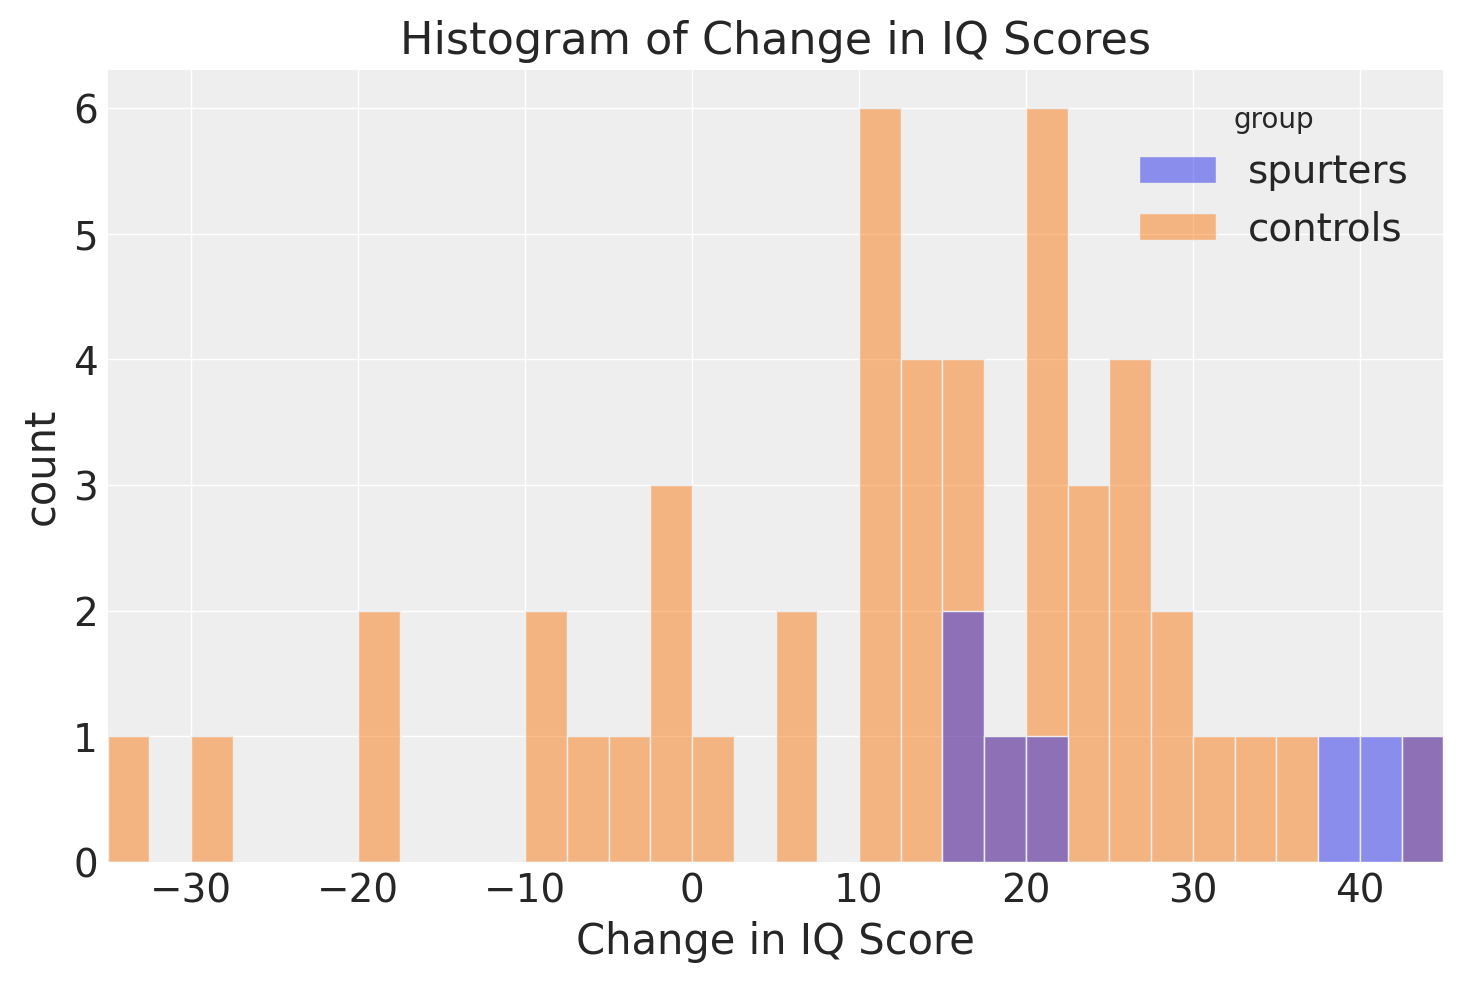

In [5]:
sns.histplot(data=df, x="value", bins=np.linspace(-35, 45, 33), hue="group")
plt.xlim(-35, 45)
plt.xlabel('Change in IQ Score')
plt.ylabel('count')
plt.title('Histogram of Change in IQ Scores');

### モデル
* 各グループの変化量は異なる正規分布に従うと仮定する。
 * spurtersの変化量のモデル $x_s \sim N(\mu_s, \lambda_s^{-1})$
 * controlsの変化量のモデル $x_c \sim N(\mu_c, \lambda_c^{-1})$
* 各グループの正規分布の平均パラメータは、同じ正規分布に従うと仮定する。
 * つまり $\mu_s, \mu_c \sim N(\mu_0, \sigma_0^2)$
* 各グループの正規分布の精度（分散の逆数）パラメータは、同じガンマ分布に従うと仮定する。
 * つまり $\lambda_s, \lambda_c \sim \text{Gam}(\alpha, \beta)$
* $N(\mu_0, \sigma_0^2)$と$\text{Gam}(\alpha, \beta)$が、事前分布。

In [6]:
def model(mu_0=0, sd_0=1, alpha=0.5, x_s=None, x_c=None):
  lambda_s = numpyro.sample("lambda_s", dist.Gamma(alpha, 100*alpha))
  lambda_c = numpyro.sample("lambda_c", dist.Gamma(alpha, 100*alpha))
  mu_s = numpyro.sample("mu_s", dist.Normal(mu_0, sd_0))
  mu_c = numpyro.sample("mu_c", dist.Normal(mu_0, sd_0))
  obs_s = numpyro.sample("obs_s", dist.Normal(mu_s, jnp.sqrt(1/lambda_s)), obs=x_s)
  obs_c = numpyro.sample("obs_c", dist.Normal(mu_c, jnp.sqrt(1/lambda_c)), obs=x_c)

### 事前分布 (1)



#### MCMC

In [7]:
mu_0 = 0.0
sd_0 = 1.0
alpha = 0.5

rng_key, rng_key_ = random.split(rng_key)
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(
    rng_key_,
    mu_0=mu_0, sd_0=sd_0, alpha=alpha,
    x_s=df[df.group=="spurters"].value.values,
    x_c=df[df.group=="controls"].value.values,
)

<ipython-input-7-bb1f27c76a4c>:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 3000/3000 [00:03<00:00, 781.56it/s, 7 steps of size 7.55e-01. acc. prob=0.90]


#### サンプルのチェック

In [8]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  lambda_c      0.00      0.00      0.00      0.00      0.00   7665.31      1.00
  lambda_s      0.00      0.00      0.00      0.00      0.00   8493.00      1.00
      mu_c      1.38      0.97      1.39     -0.30      2.95   7064.42      1.00
      mu_s      0.26      1.00      0.25     -1.33      1.96   8223.53      1.00

Number of divergences: 0


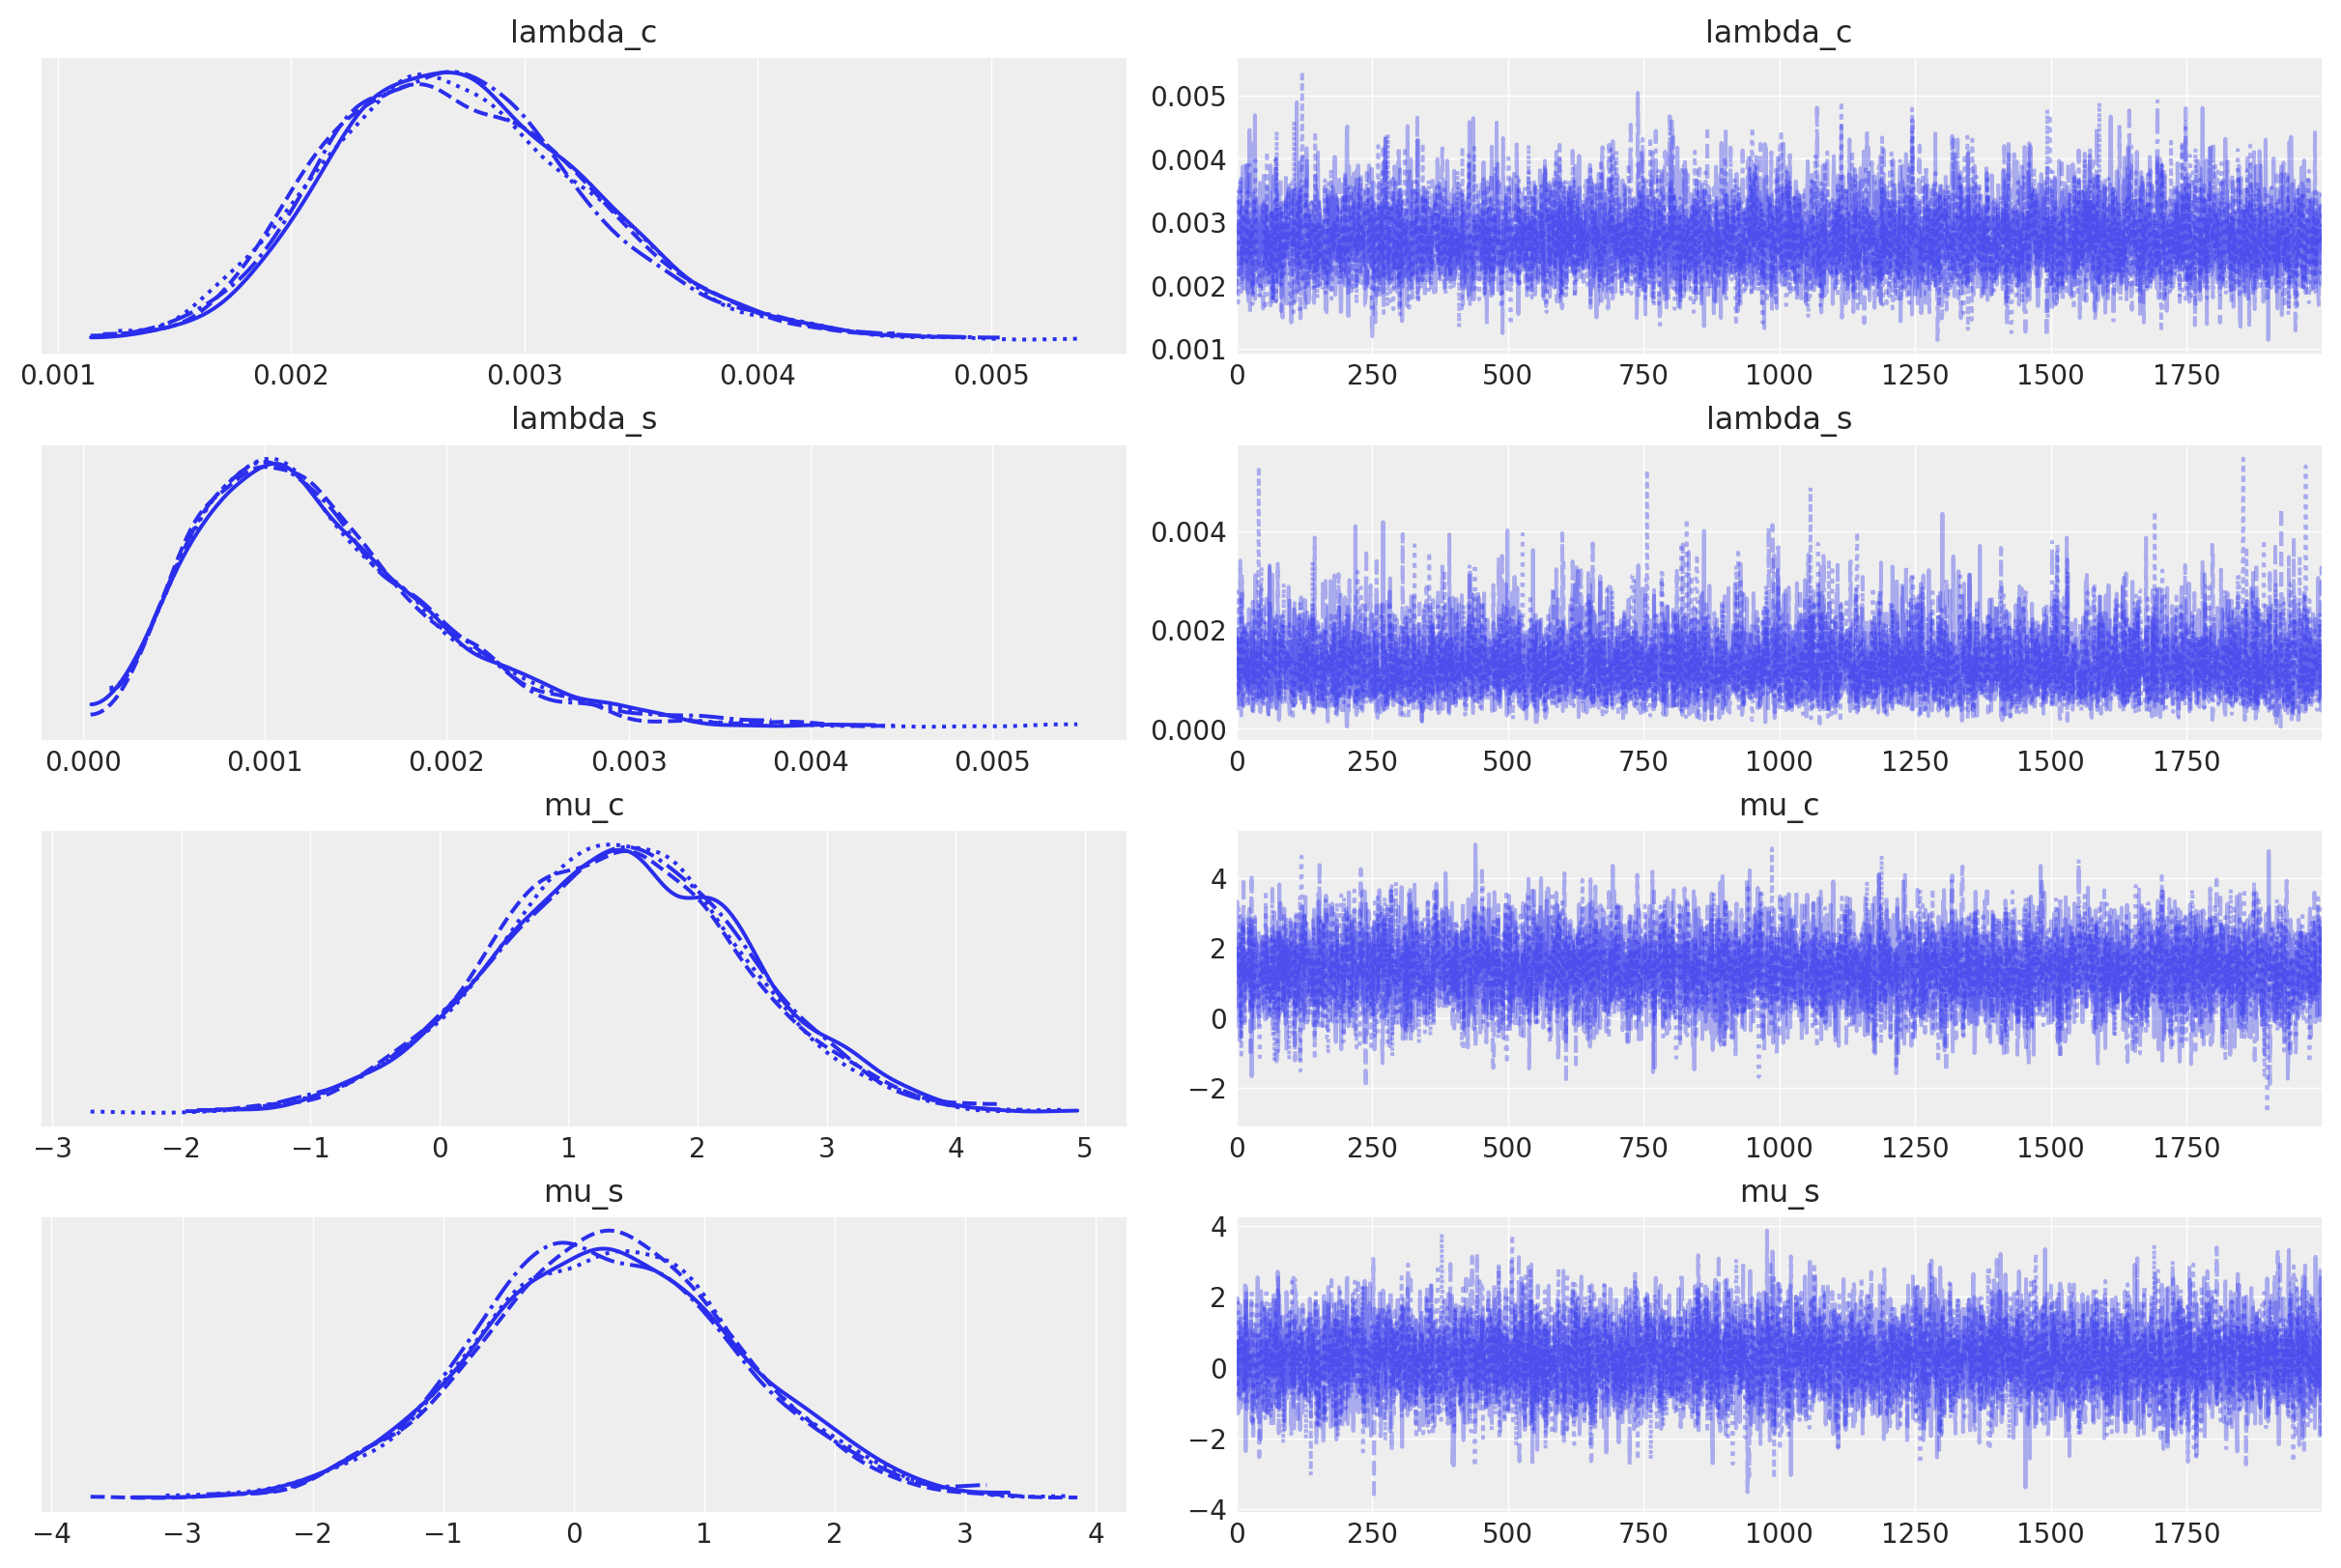

In [9]:
idata_1 = az.from_numpyro(mcmc)
az.plot_trace(idata_1);

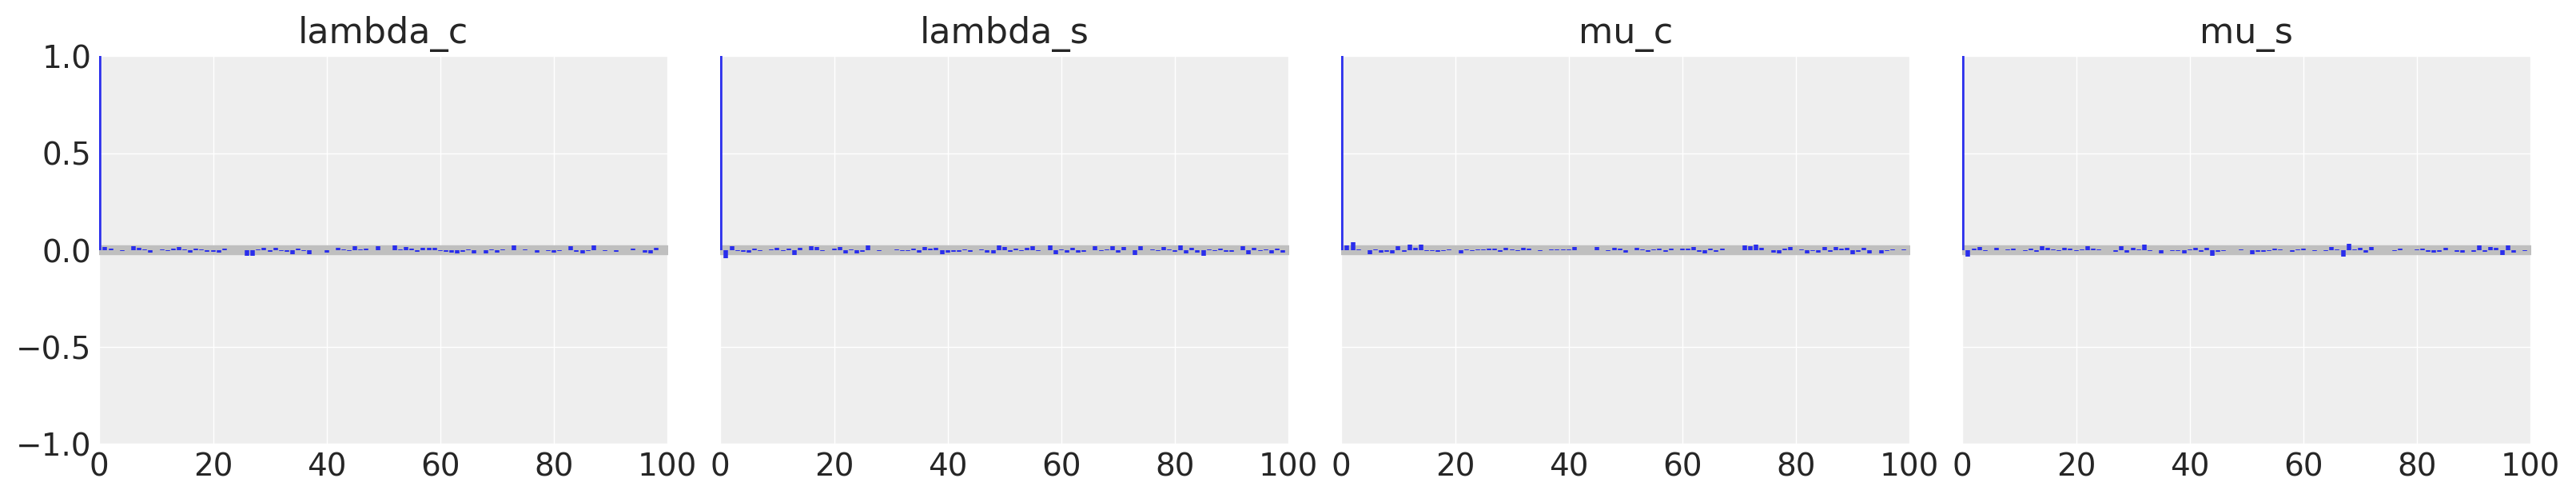

In [10]:
az.plot_autocorr(idata_1, combined=True, figsize=(16,3));

* この設定の下で、$p(\mu_s > \mu_c | \mathbf{x}_s, \mathbf{x}_c)$を求めてみる。

In [11]:
posterior = idata_1.posterior
n_samples = posterior.dims['chain'] * posterior.dims['draw']
(posterior.mu_s > posterior.mu_c).sum().data / n_samples

0.20225

### 事前分布 (2)

#### MCMC

In [12]:
mu_0 = np.array(x_s + x_c).mean()
sd_0 = 100.0
alpha = 0.5

rng_key, rng_key_ = random.split(rng_key)
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(
    rng_key_,
    mu_0=mu_0, sd_0=sd_0, alpha=alpha,
    x_s=df[df.group=="spurters"].value.values,
    x_c=df[df.group=="controls"].value.values,
)

<ipython-input-12-69f91d89263d>:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1554.00it/s, 7 steps of size 5.93e-01. acc. prob=0.92]


In [13]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  lambda_c      0.00      0.00      0.00      0.00      0.01   8707.89      1.00
  lambda_s      0.01      0.00      0.01      0.00      0.01   6636.96      1.00
      mu_c     12.08      2.37     12.11      8.07     15.85   8528.41      1.00
      mu_s     27.45      5.51     27.40     18.40     36.15   5329.73      1.00

Number of divergences: 0


#### サンプルのチェック

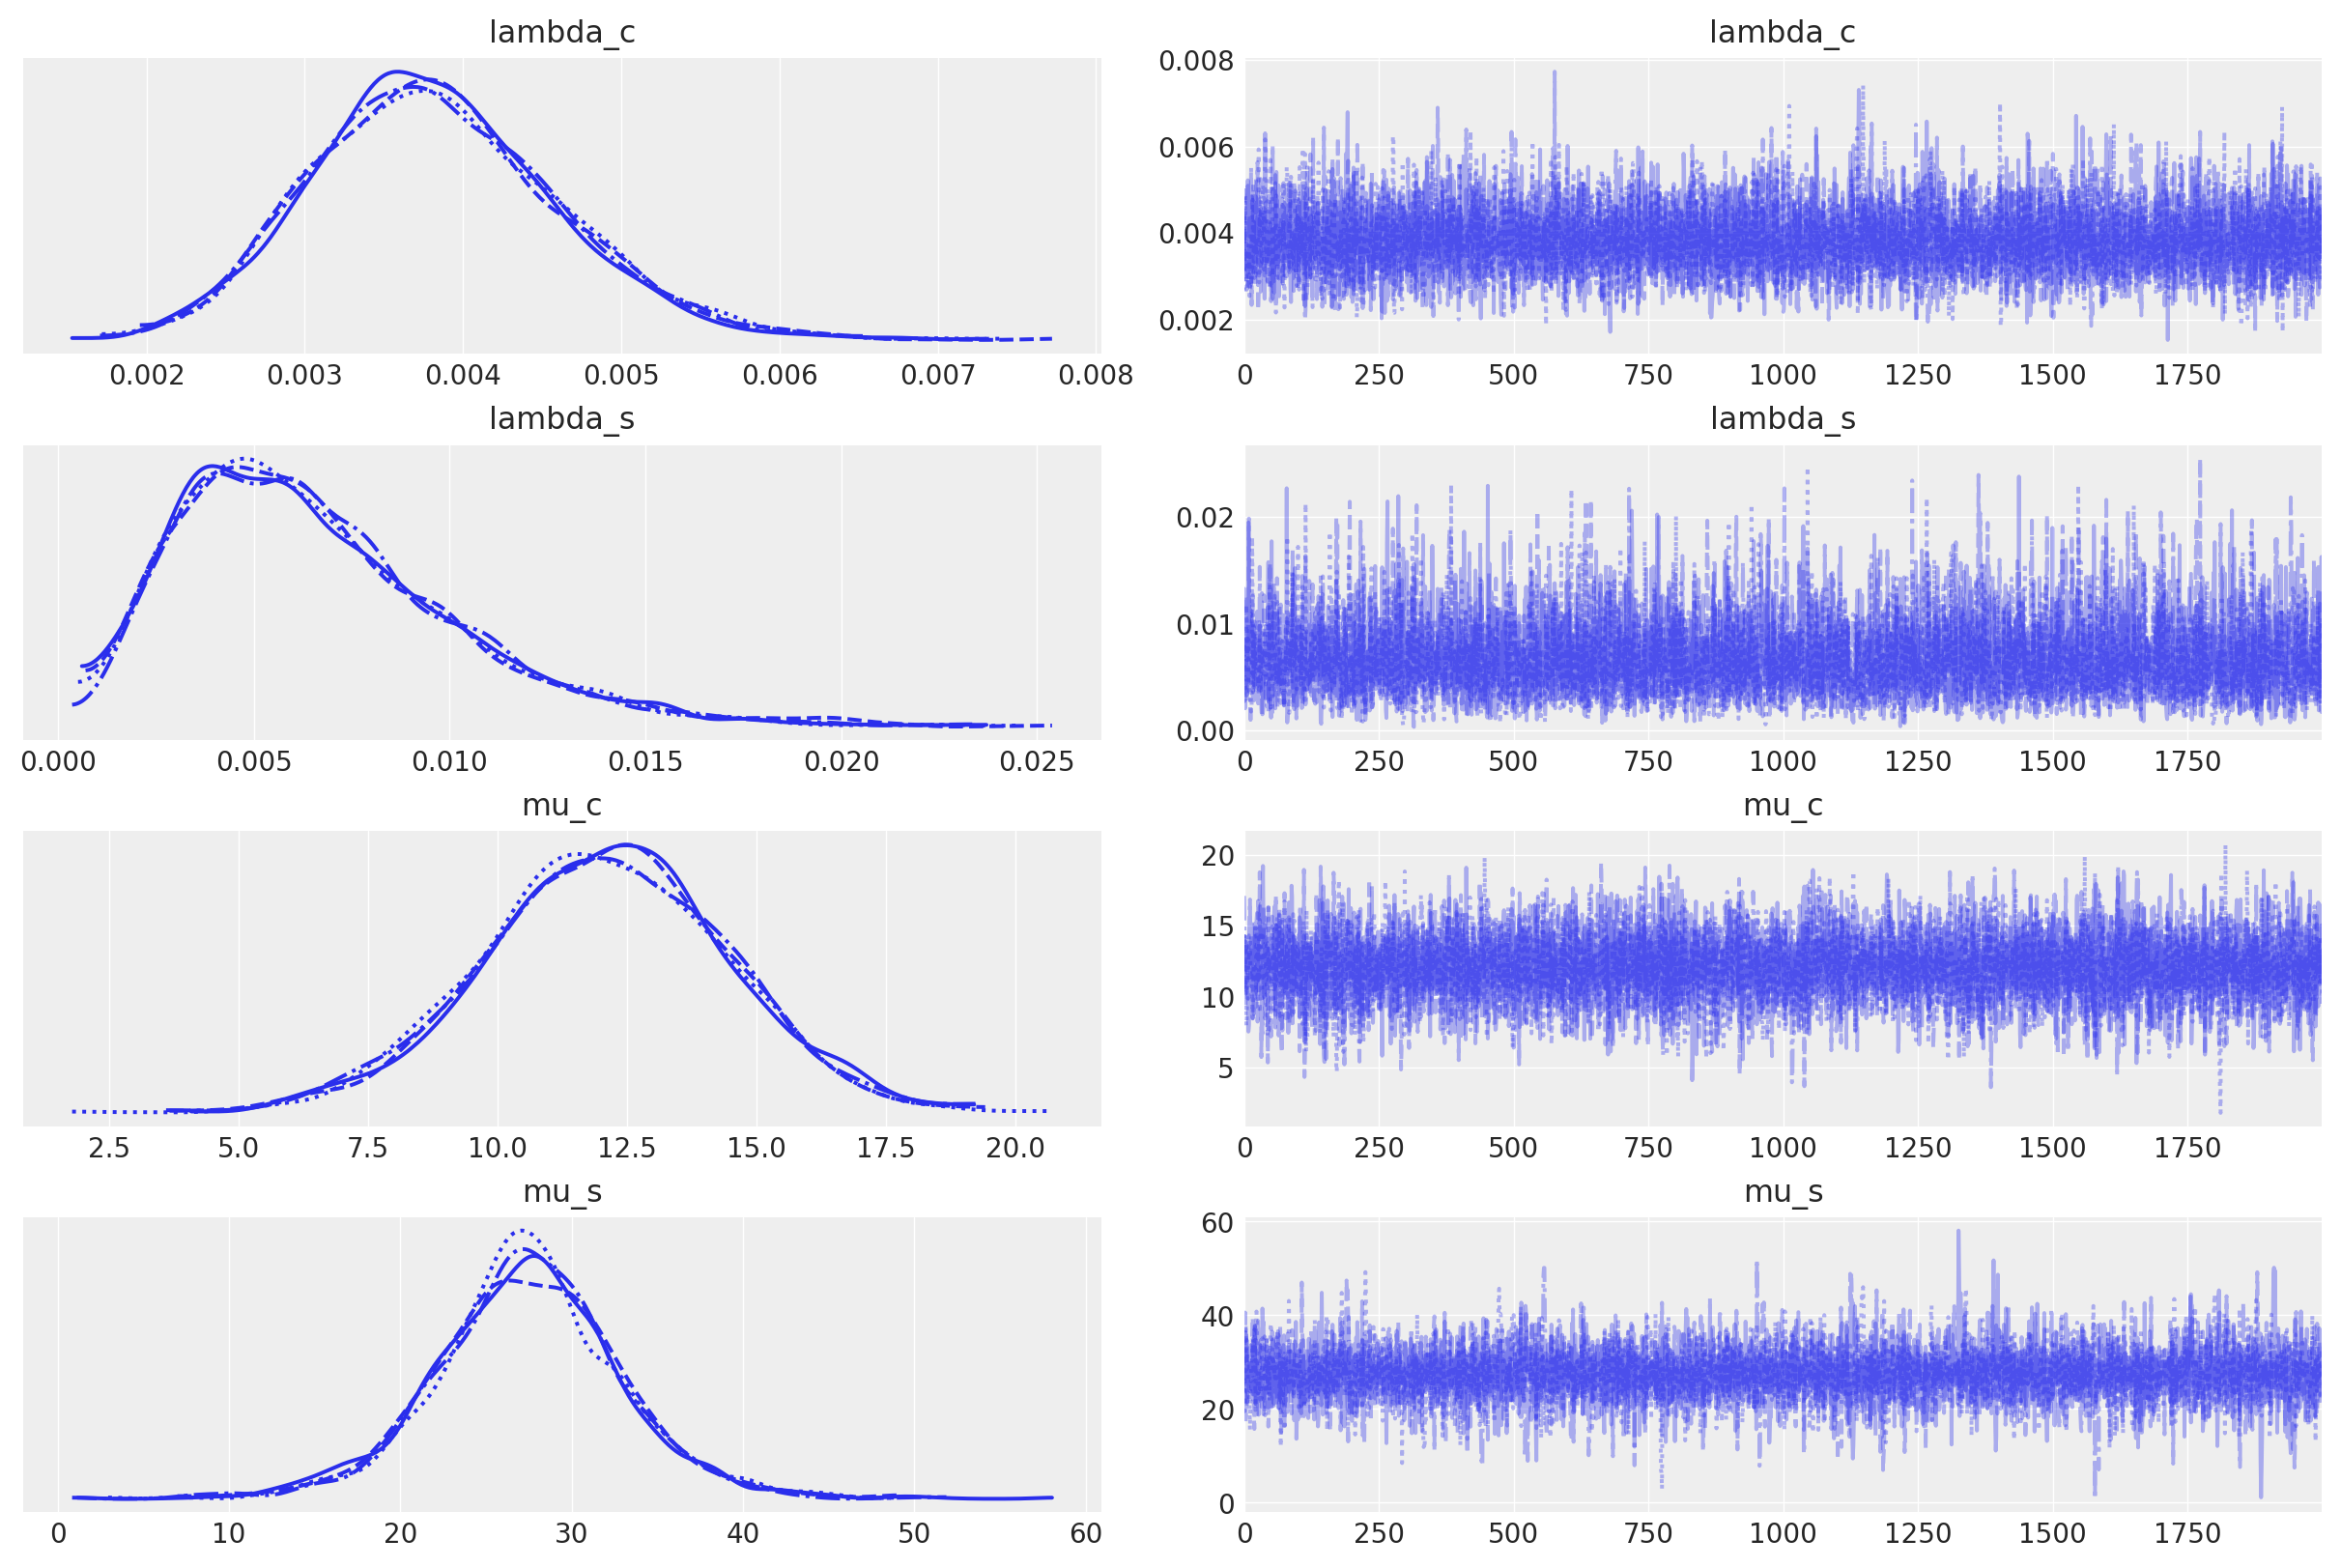

In [14]:
idata_2 = az.from_numpyro(mcmc)
az.plot_trace(idata_2);

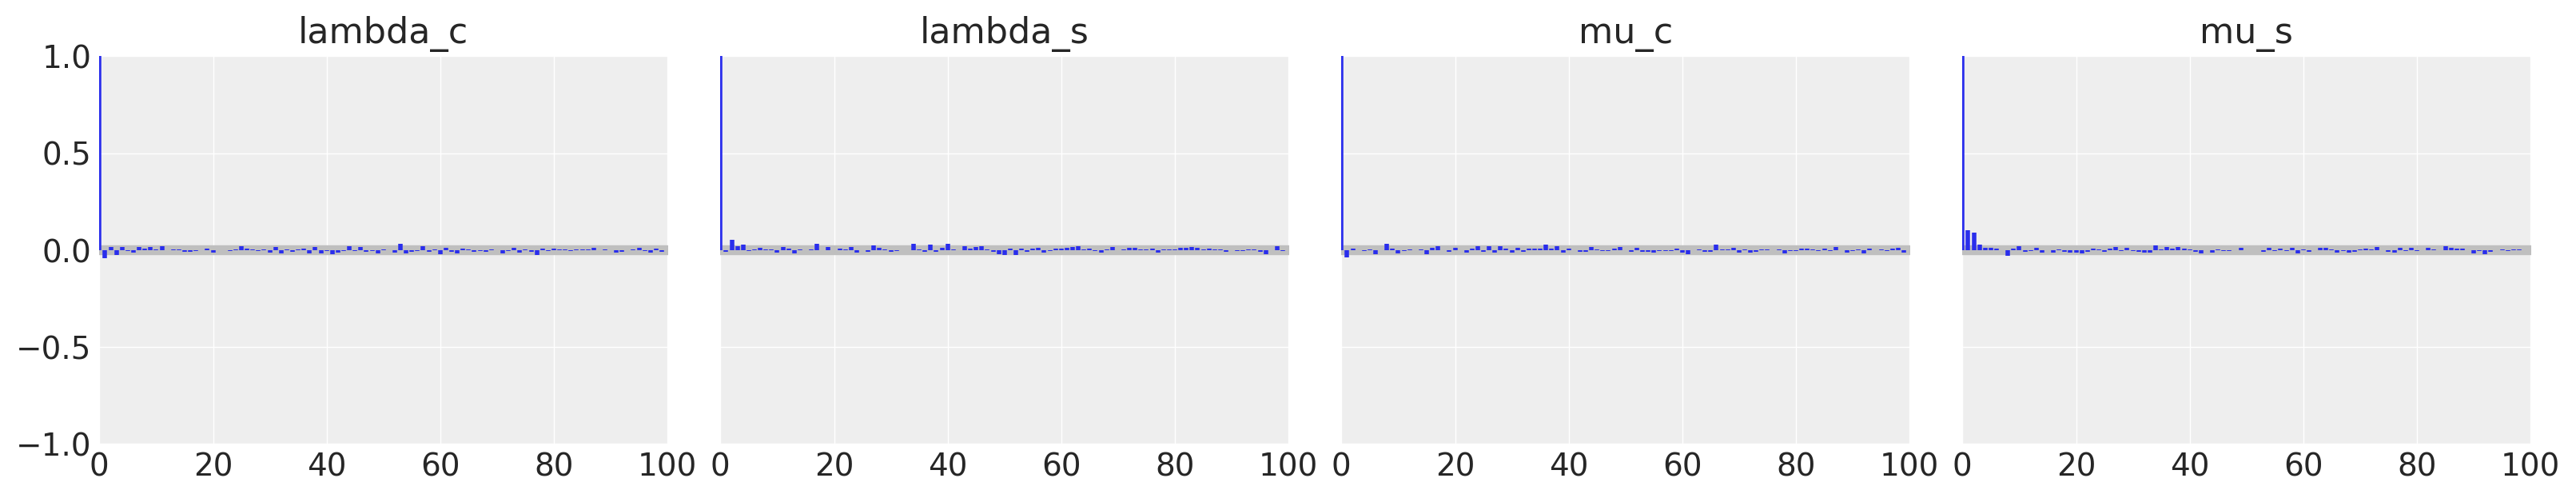

In [15]:
az.plot_autocorr(idata_2, combined=True, figsize=(16,3));

* この設定の下で、$p(\mu_s > \mu_c | \mathbf{x}_s, \mathbf{x}_c)$を求めてみる。

In [16]:
posterior = idata_2.posterior
n_samples = posterior.dims['chain'] * posterior.dims['draw']
(posterior.mu_s > posterior.mu_c).sum().data / n_samples

0.99075

### 事前分布 (3)-新規追加

#### MCMC

In [17]:
print("max:", np.array(x_s + x_c).max())
print("min:", np.array(x_s + x_c).min())
print("mean:", np.array(x_s + x_c).mean())
print("var:", np.array(x_s + x_c).var())
print("std:", np.array(x_s + x_c).std())

max: 44
min: -33
mean: 14.0
var: 269.8909090909091
std: 16.428356859129554


In [18]:
# 観測データの最大値を設定
mu_0 = np.array(x_s + x_c).max()

sd_0 = 150

alpha = 0.6

rng_key, rng_key_ = random.split(rng_key)
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(
    rng_key_,
    mu_0=mu_0, sd_0=sd_0, alpha=alpha,
    x_s=df[df.group=="spurters"].value.values,
    x_c=df[df.group=="controls"].value.values,
)

<ipython-input-18-59a3176a81a6>:9: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2270.97it/s, 7 steps of size 6.29e-01. acc. prob=0.90]


#### サンプルのチェック

In [20]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  lambda_c      0.00      0.00      0.00      0.00      0.01   8870.04      1.00
  lambda_s      0.01      0.00      0.01      0.00      0.01   7053.27      1.00
      mu_c     12.03      2.42     12.09      8.32     16.32   7937.70      1.00
      mu_s     27.48      5.34     27.48     18.92     36.08   5386.92      1.00

Number of divergences: 0


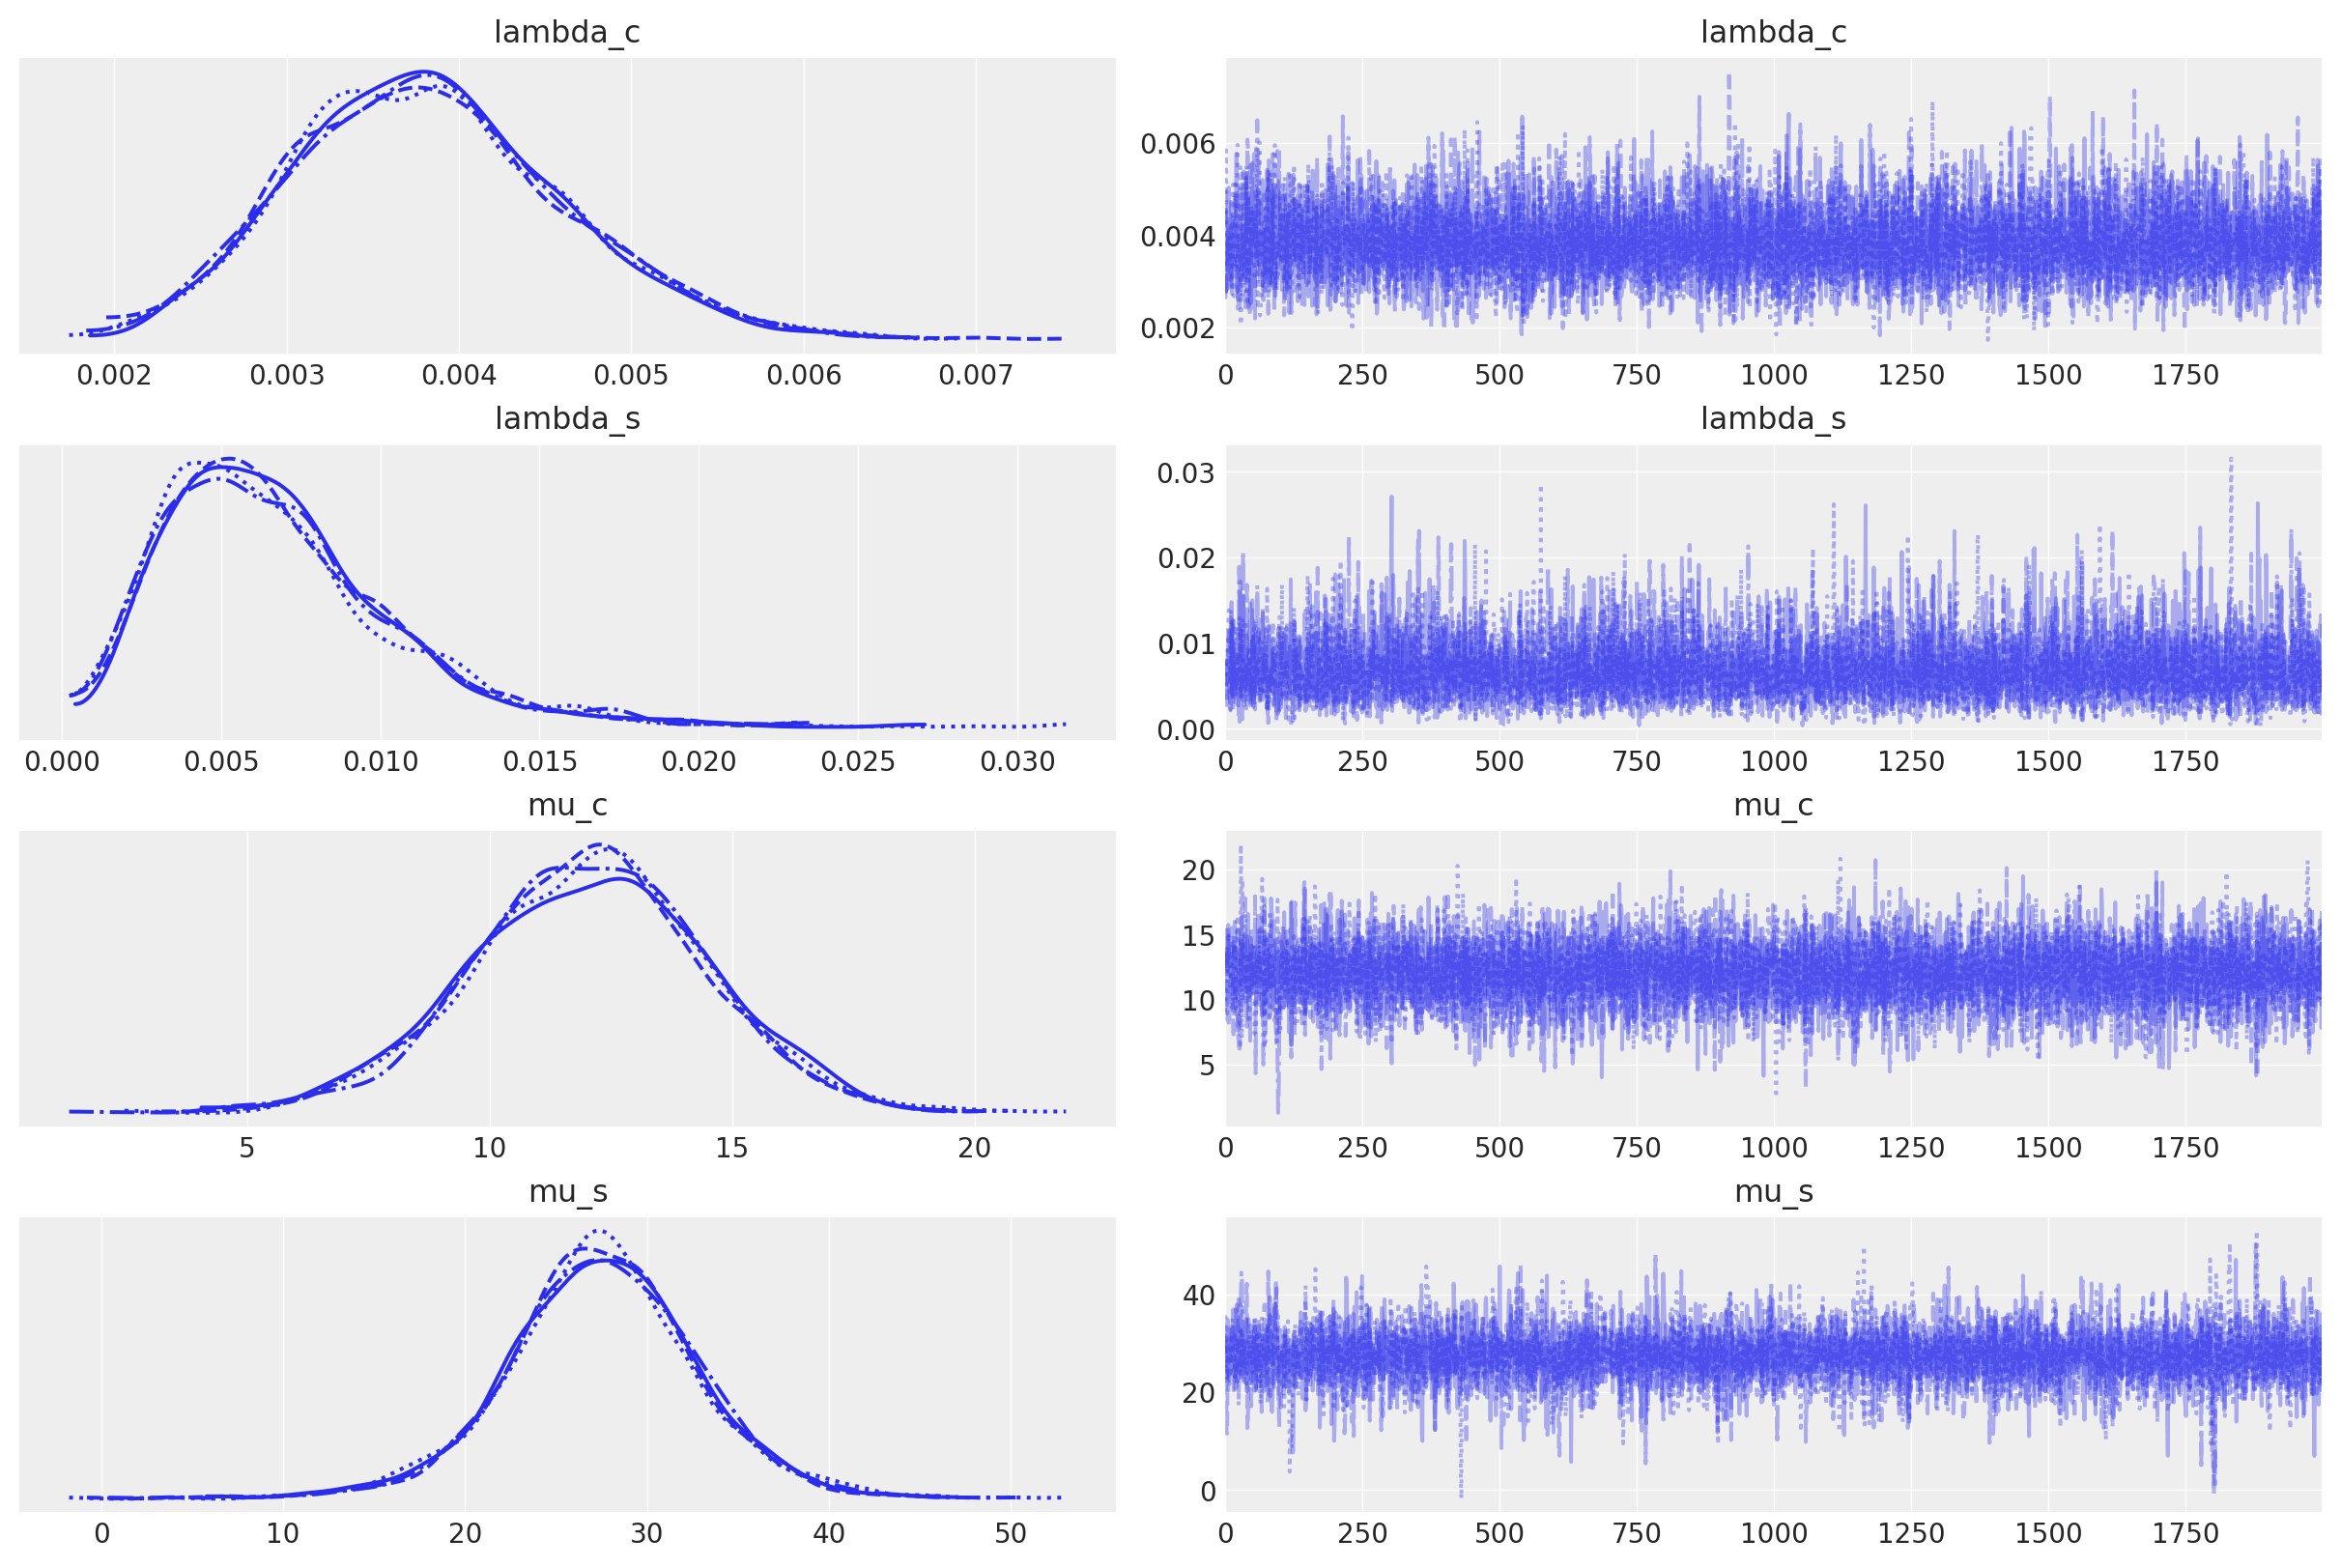

In [21]:
idata_3 = az.from_numpyro(mcmc)
az.plot_trace(idata_3);

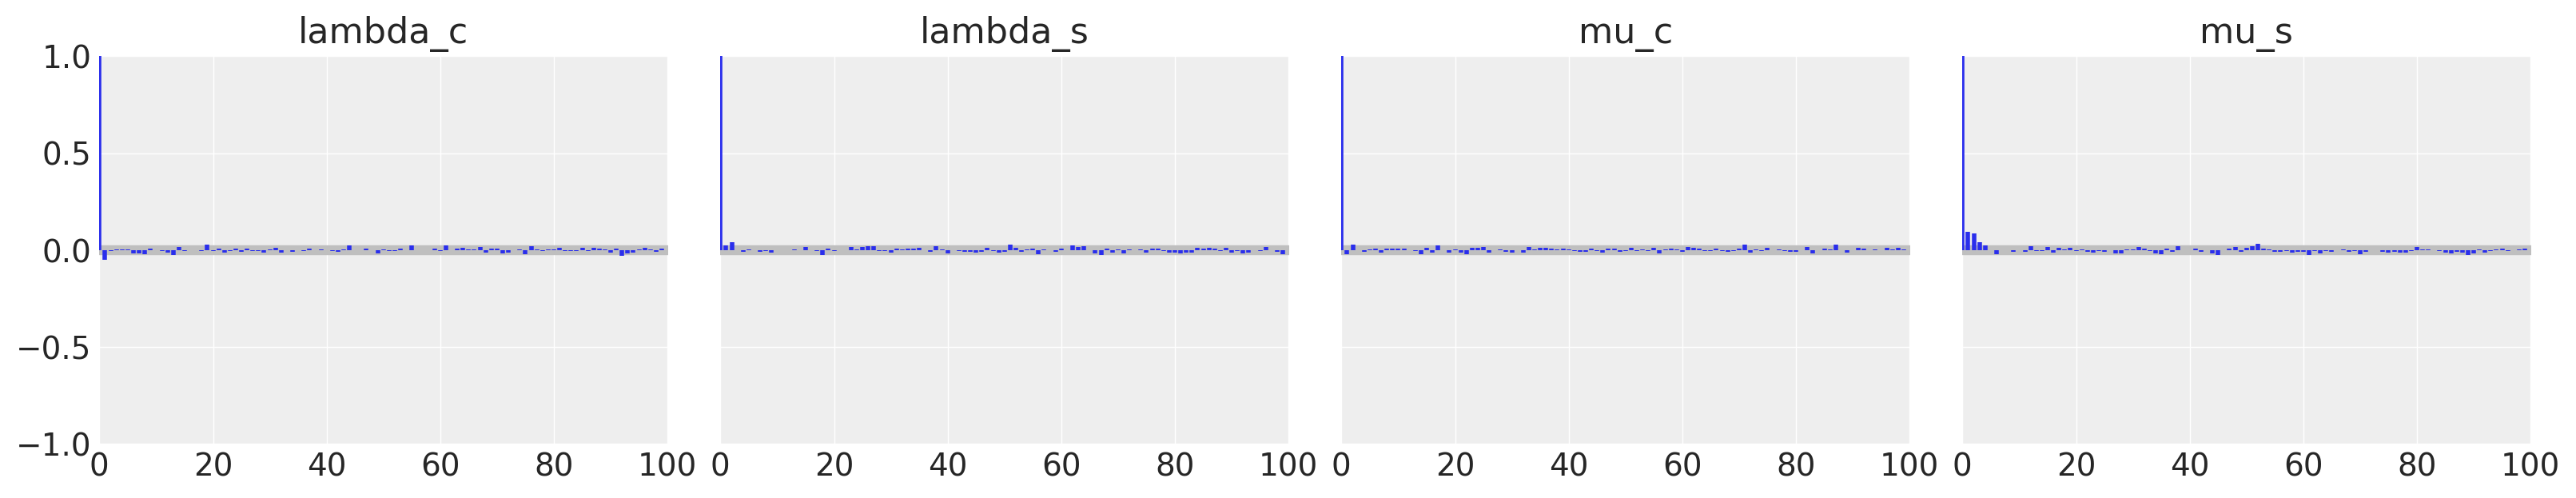

In [22]:
az.plot_autocorr(idata_3, combined=True, figsize=(16,3));

* この設定の下で、$p(\mu_s > \mu_c | \mathbf{x}_s, \mathbf{x}_c)$を求めてみる。

In [23]:
posterior = idata_3.posterior
# 4 * 2000
n_samples = posterior.dims['chain'] * posterior.dims['draw']
(posterior.mu_s > posterior.mu_c).sum().data / n_samples

0.990875

### モデルの比較

* まず、spurtersのデータの予測確率を使って比較する。

In [24]:
az.compare({'model_1': idata_1, 'model_2': idata_2, 'model_3': idata_3}, var_name="obs_s")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_3,0,-28.848920,1.209328,0.000000,1.000000e+00,0.717093,0.000000,False,log
model_2,1,-28.873459,1.201227,0.024539,0.000000e+00,0.706974,0.017654,False,log
model_1,2,-34.367809,0.426895,5.518889,1.110223e-16,1.218285,0.878429,False,log


* 次に、controlsのデータの予測確率を使って比較する。

In [25]:
az.compare({'model_1': idata_1, 'model_2': idata_2, 'model_3': idata_3}, var_name="obs_c")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_2,0,-203.721737,2.268759,0.000000,0.857651,5.812922,0.000000,False,log
model_3,1,-203.757035,2.304768,0.035298,0.000000,5.807251,0.021265,False,log
model_1,2,-211.062866,0.631723,7.341129,0.142349,3.573782,4.589664,False,log


In [26]:
print(f"We have {len(x_s)} spurters and {len(x_c)} controls.")

We have 7 spurters and 48 controls.


#### 考査
* 事前分布(1)： mu=0,  sd=1,   alpha=0.5
* 事前分布(2)： mu=14, sd=100, alpha=0.5
* 事前分布(3)： mu=44, sd=150, alpha=0.6
* 事前分布(2)は事前分布(1)より、結果は大幅に良くなりました。
* 事前分布(3)は事前分布(2)より、結果はあまり変わらないです。